# visualzing output of WDM on zf

## imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install scanpy -q

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 30.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.0/129.0 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 6.3 MB/s eta 0:00:00


In [3]:
import pandas as pd
import scanpy as sc
import numpy as np
import torch
import sys
from scipy.spatial.distance import cdist
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import sys
import importlib

In [22]:
filehandle_wdm = 'drive/Othercomputers/numac/GitHub/WDM/'
filehandle_load_output = 'drive/Othercomputers/numac/GitHub/celltypediscovery/_wdm_save/'
filehandle_zf = 'drive/MyDrive/DX/_data/zebrafish/cleaned_common_pca/'
filehandle_ctd = 'drive/Othercomputers/numac/GitHub/celltypediscovery/'


sys.path.insert(0, filehandle_wdm)
sys.path.insert(0, filehandle_load_output)
sys.path.insert(0, filehandle_zf)
sys.path.insert(0, filehandle_ctd)

import clustering
import util_LR
import util_zf
import FRLC_LRDist

## reload

In [58]:
importlib.reload(clustering)
importlib.reload(util_LR)
importlib.reload(util_zf)
importlib.reload(FRLC_LRDist)

<module 'FRLC_LRDist' from '/content/drive/Othercomputers/numac/GitHub/WDM/FRLC_LRDist.py'>

## device

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'On device: {device}')
dtype = torch.float64

On device: cuda


## load zf: spatial, annotation hard clusterings as $Q$'s

In [9]:
# daniocell_dir = '/scratch/gpfs/ph3641/zebrafish/daniocell.h5ad'
# adata_daniocell = sc.read_h5ad(daniocell_dir)
# stages = np.unique(adata_daniocell.obs['hpf'].values)

zf_list = ['zf3', 'zf5', 'zf10', 'zf12', 'zf18', 'zf24']
zf_names = zf_list
filehandles_zf = [filehandle_zf + 'pair' + str(k) + '/' for k in range(len(zf_list))]
N = len(filehandles_zf)

spatial_list = []
exclude_rows = [None, None, None, None, None, None] # [1099, None, None, 325, None, None]

for i in range(len(zf_list)):
    file_spatial = filehandles_zf[i] + zf_names[i] +'_spatial.npy'
    if i == len(zf_list) - 1:
        file_spatial = filehandles_zf[i-1] + zf_names[i] +'_spatial.npy'
    spatial = np.load(file_spatial)
    nidx = exclude_rows[i]
    if nidx is not None:
        spatial = np.concatenate((spatial[:nidx,:], spatial[nidx+1:,:]))
    spatial_list.append(spatial)

In [10]:
N = len(filehandles_zf)
Qs = [None]*(N-1)
Rs = [None]*(N-1)

key = 'bin_annotation'

labels = []

for i in range(N-2, -1, -1):

    s1_name = zf_names[i]
    s2_name = zf_names[i+1]

    print(f'Slice pair {i}, aligning {s1_name} to {s2_name}')

    adata_pair = sc.read_h5ad(filehandle_zf + f'pair{i}/' + s1_name + '_' + s2_name + '.h5ad')

    adata1 = adata_pair[adata_pair.obs['timepoint'] == 1]
    # sc.pp.normalize_total(adata1)
    # sc.pp.log1p(adata1)

    adata2 = adata_pair[adata_pair.obs['timepoint'] == 2]
    # sc.pp.normalize_total(adata2)
    # sc.pp.log1p(adata2)

    encoder1 = OneHotEncoder(sparse_output=False)
    ys_onehot1 = encoder1.fit_transform(adata1.obs[key].values.reshape(-1, 1))
    _Q = ys_onehot1 / np.sum(ys_onehot1)

    encoder2 = OneHotEncoder(sparse_output=False)
    ys_onehot2 = encoder2.fit_transform(adata2.obs[key].values.reshape(-1, 1))
    _R = ys_onehot2 / np.sum(ys_onehot2)

    labels.append(list(encoder2.categories_[0]))

    if i == 0:
        labels.append(list(encoder1.categories_[0]))

    _Q, _R = torch.from_numpy(_Q).to(device).float(), torch.from_numpy(_R).to(device).float()

    # Filter rows
    nidx_1, nidx_2 = exclude_rows[i], exclude_rows[i+1]
    if nidx_1 is not None:
        _Q = torch.cat((_Q[:nidx_1,:], _Q[nidx_1+1:,:]))
    if nidx_2 is not None:
        _R = torch.cat((_R[:nidx_2,:], _R[nidx_2+1:,:]))

    Qs[i], Rs[i] = _Q, _R

Slice pair 4, aligning zf18 to zf24
Slice pair 3, aligning zf12 to zf18
Slice pair 2, aligning zf10 to zf12
Slice pair 1, aligning zf5 to zf10
Slice pair 0, aligning zf3 to zf5


## set ranks, set `i` = first timepoint of three: `i`, `i+1`, `i+2`

In [13]:
ranks = [(3,7),(7,7),(7,11),(11,14),(14,19)]

i=2

r1, r2 = ranks[i]
r2, r3 = ranks[i+1]

## load features and spatial coords specific to the triple

In [15]:
s0_name = zf_names[i]
s1_name = zf_names[i+1]
s2_name = zf_names[i+2]

filehandle_pair1 = filehandle_zf + 'pair' + str(i) + '/'
filehandle_pair2 = filehandle_zf + 'pair' + str(i+1) + '/'

X0 = np.load(filehandle_pair1 + s0_name + '_feature.npy')
X1 = np.load(filehandle_pair1 + s1_name + '_feature.npy')
X2 = np.load(filehandle_pair2 + s2_name + '_feature.npy')

S0 = spatial_list[i]
S1 = spatial_list[i+1]
S2 = spatial_list[i+2]

## load `WDM` output

In [38]:
wdm_Q0 = np.load(filehandle_load_output + 'wdm_Q0.npy')
wdm_Q1 = np.load(filehandle_load_output + 'wdm_Q1.npy')
wdm_Q2 = np.load(filehandle_load_output + 'wdm_Q2.npy')

wdm_T0 = np.load(filehandle_load_output + 'wdm_T0.npy')
wdm_T1 = np.load(filehandle_load_output + 'wdm_T1.npy')

ann_Q0 = np.load(filehandle_load_output + 'ann_Q0.npy')

ann_Q1 = np.load(filehandle_load_output + 'ann_Q1.npy')
ann_Q1_imp = np.load(filehandle_load_output + 'ann_Q1_imp.npy')

ann_Q2 = np.load(filehandle_load_output + 'ann_Q2.npy')

ann_T0_imp = np.load(filehandle_load_output + 'ann_T0_imp.npy')
ann_T1_imp = np.load(filehandle_load_output + 'ann_T1_imp.npy')

ann_T0 = np.load(filehandle_load_output + 'ann_T0.npy')
ann_T1 = np.load(filehandle_load_output + 'ann_T0.npy')

## load labels

In [23]:
slice0_types = list(np.load(filehandle_ctd + 'a_gt_types/' + 'slice0_types.npy'))
slice1_types = list(np.load(filehandle_ctd + 'a_gt_types/' + 'slice1_types.npy'))
slice2_types = list(np.load(filehandle_ctd + 'a_gt_types/' + 'slice2_types.npy'))
slice3_types = list(np.load(filehandle_ctd + 'a_gt_types/' + 'slice3_types.npy'))
slice4_types = list(np.load(filehandle_ctd + 'a_gt_types/' + 'slice4_types.npy'))
slice5_types = list(np.load(filehandle_ctd + 'a_gt_types/' + 'slice5_types.npy'))

In [54]:
ct_labels = [ list(set(slice0_types)),
               list(set(slice1_types)),
                list(set(slice2_types)),
                list(set(slice3_types)),
                list(set(slice4_types)),
                list(set(slice5_types))]

ct_ann_0 = ct_labels[i]
ct_ann_1 = ct_labels[i+1]
ct_ann_2 = ct_labels[i+2]

node_labels = [ct_ann_0, ct_ann_1, ct_ann_2]

In [29]:
ct_ann_0

['Posterior Neural Keel',
 'Periderm',
 'Yolk Syncytial Layer',
 'Segmental Plate, Tail Bud',
 'Anterior Neural Keel',
 'Paraxial Mesoderm, Neural Keel',
 'Notochord']

In [30]:
ct_ann_1

['Yolk Syncytial Layer, Periderm',
 'Lateral Plate Mesoderm',
 'Adaxial Cell',
 'Periderm',
 'Yolk Syncytial Layer',
 'Segmental Plate, Tail Bud',
 'Optic Vesicle',
 'Polster',
 'Notochord',
 'Neural Rod',
 'Somite']

In [31]:
ct_ann_2

['Yolk Syncytial Layer, Periderm',
 'Notochord',
 'Angioblastic Mesenchymal Cell',
 'Hatching Gland',
 'Pronephros',
 'Nervous System',
 'Immature Eye, Midbrain',
 'Yolk Syncytial Layer',
 'Neural Crest',
 'Segmental Plate, Tail Bud',
 'Forebrain',
 'Erythroid Lineage Cell',
 'Neural Crest, Otic Vesicle',
 'Somite']

# transitions between three annotated slices

## plot transitions with ct labels

In [39]:
ann_labels_0, ann_labels_1 = clustering.max_likelihood_clustering(ann_Q0, ann_Q1)
_, ann_labels_2 = clustering.max_likelihood_clustering(ann_Q1, ann_Q2)

cluster_list = [ann_labels_0, ann_labels_1, ann_labels_2]

In [43]:
populations0 = [len(np.where(cluster_list[0] == label)[0]) for label in set(cluster_list[0])]
populations1 = [len(np.where(cluster_list[1] == label)[0]) for label in set(cluster_list[1])]
populations2 = [len(np.where(cluster_list[2] == label)[0]) for label in set(cluster_list[2])]

population_list = [populations0, populations1, populations2]
population_list

[[49, 198, 121, 101, 6, 339, 222],
 [438, 5, 443, 10, 45, 132, 203, 292, 265, 168, 80],
 [155, 356, 298, 130, 21, 316, 467, 61, 758, 16, 20, 375, 22, 53]]

In [51]:
set(ann_labels_0);

In [52]:
set(ann_labels_1);

In [53]:
set(ann_labels_2);

In [47]:
label_list = []

cs = 0

for i in range(len(cluster_list)):
    label_list.append(list(set(cluster_list[i] + cs)))
    cs += len(set(cluster_list[i]))

label_list

[[0, 1, 2, 3, 4, 5, 6],
 [7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17],
 [18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]]

In [50]:
color_dict = clustering.get_color_scheme(label_list, color_scheme='tab')
color_dict;

In [60]:
transition_list = [ann_T0, ann_T1]

clustering.plot_labeled_differentiation(population_list,
                                        transition_list,
                                        label_list,
                                        color_dict,
                                        node_labels,
                                        dotsize_factor=1,
                                        linethick_factor=5)


clustering.plot_cluster_list([S0, S1, S2],
                             cluster_list,
                             color_scheme='tab',
                             title=None,
                             save_name=None,
                             flip=False)

Output hidden; open in https://colab.research.google.com to view.

## plot ct-labeled clustering from annotations

# imputed clustering

## first, look at imputed clustering, max likelihood labels.

In [17]:
ml_labels_Q0, ml_labels_Q1 = clustering.max_likelihood_clustering(ann_Q0, ann_Q1_imp)
_, ml_labels_Q2 = clustering.max_likelihood_clustering(ann_Q1_imp, ann_Q2)

S0_torch = torch.from_numpy(S0)
S1_torch = torch.from_numpy(S1)
S2_torch = torch.from_numpy(S2)

Number of clusters in slice 1: 7
Number of clusters in slice 2: 11
Number of clusters in common: 7
Number of clusters total: 11


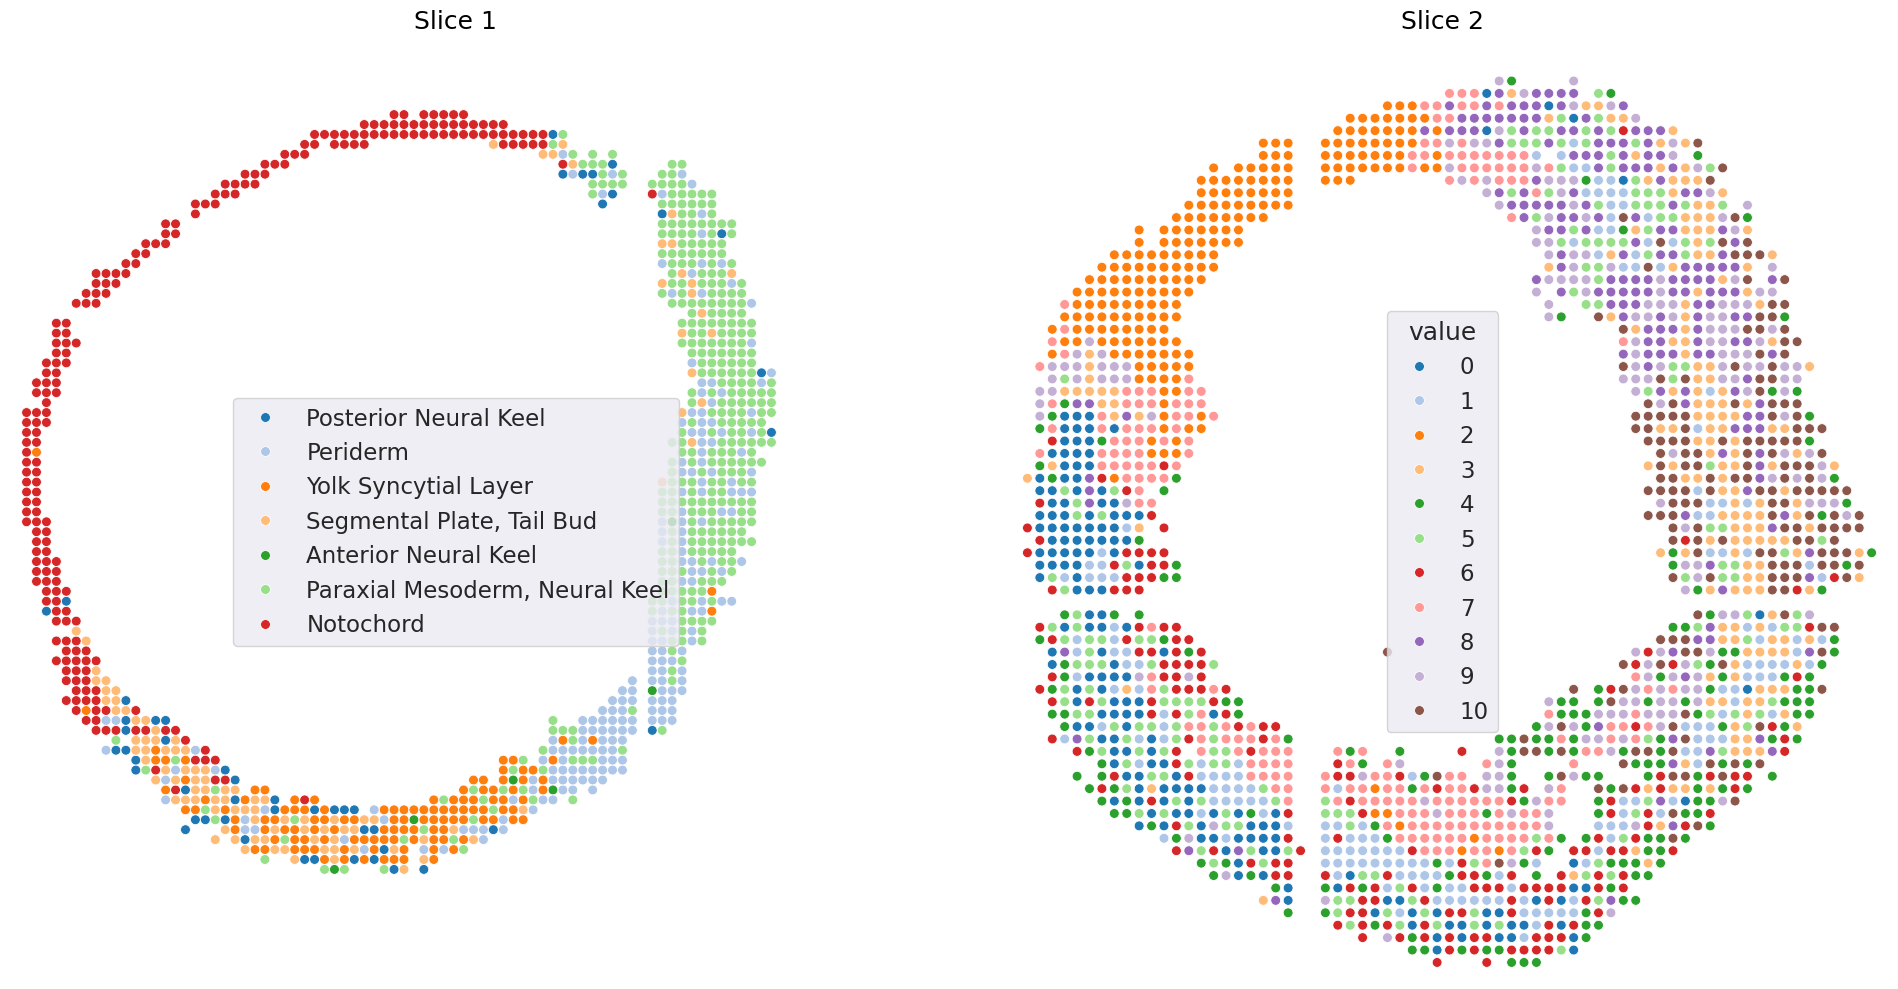

In [37]:
cell_type_labels=[ct_ann_0, None]
clustering.plot_cluster_pair(S0_torch, S1_torch, ml_labels_Q0, ml_labels_Q1, dotsize=50, cell_type_labels=cell_type_labels)

## view clusters from `WDM`

In [ ]:

T12 = WDM.T_gammas[1]
ml_labels_W, ml_labels_H = clustering.ancestral_clustering(Q1.cpu().numpy(), Q2.cpu().numpy(),T12.cpu().numpy(), full_P=False)
clustering.plot_cluster_pair(xs,
                            xs2,
                                 ml_labels_W,
                                 ml_labels_H, dotsize=100)

Output hidden; open in https://colab.research.google.com to view.

## plot and save clusterings from above _(moving to a second nb)_

In [ ]:
spatial_list2 = []
for i in range(len(zf_list)):
    file_spatial = filehandles_zf[i] + zf_names[i] +'_spatial.npy'
    if i == len(zf_list) - 1:
        file_spatial = filehandles_zf[i-1] + zf_names[i] +'_spatial.npy'
    spatial = np.load(file_spatial)
    spatial_list2.append(spatial)

i = 3
xs = torch.from_numpy(spatial_list[i+1]).to(device)
xs2 = torch.from_numpy(spatial_list2[i+2]).to(device)

ml_labels_W, ml_labels_H = clustering.max_likelihood_clustering(Q_t.cpu().numpy(), R2.cpu().numpy())
print(xs.shape)
print(xs2.shape)
print(len(ml_labels_W))
print(len(ml_labels_H))

clustering.plot_cluster_pair(xs,
                            xs2,
                                 ml_labels_W,
                                 ml_labels_H, dotsize=100)

np.save('wasserstein_joint_ML.npy', np.array(ml_labels_W))

In [ ]:
ml_labels_W, ml_labels_H = clustering.ancestral_clustering(Q_t.cpu().numpy(),R2.cpu().numpy(),T_ttp1.cpu().numpy(), full_P=False)
clustering.plot_cluster_pair(xs,
                            xs2,
                                 ml_labels_W,
                                 ml_labels_H, dotsize=100)

np.save('wasserstein_joint.npy', np.array(ml_labels_W))

In [ ]:
xs0 = torch.from_numpy(spatial_list[i]).to(device)
ml_labels_W, ml_labels_H = clustering.ancestral_clustering(Q1.cpu().numpy(),Q_t.cpu().numpy(),T_tm1t.cpu().numpy(), full_P=False)
clustering.plot_cluster_pair(xs0,
                            xs,
                                 ml_labels_W,
                                 ml_labels_H, dotsize=100)

In [ ]:
init_args = (None, R2, None)

Qb,Rb,Tb, errs = DeSTOT_LRDist.DeSTOT_LR_opt(C_factors23, \
                                              A_factors22, \
                                             A_factors33, \
                                          a=None, b=None, \
                                          r=r2, r2=r3, max_iter= 220, device=device, \
                                         returnFull=False, alpha=alpha, beta=beta, \
                                        min_iter = 200, initialization='Full', tau_out=tau_out, tau_in=tau_in, gamma=gamma, \
                                        dtype=torch.float64, updateR = False, updateQ = True, updateT = True, init_args=init_args)
gQ = Qb.T @ torch.ones(Qb.shape[0]).type(torch.DoubleTensor).to(device)
print(gQ)

In [ ]:
ml_labels_W, ml_labels_H = clustering.ancestral_clustering(Qb.cpu().numpy(),Rb.cpu().numpy(),Tb.cpu().numpy(), full_P=False)
clustering.plot_cluster_pair(xs,
                            xs2,
                                 ml_labels_W,
                                 ml_labels_H, dotsize=100)
np.save('wasserstein_backward.npy', np.array(ml_labels_W))